<a href="https://colab.research.google.com/github/micah-shull/LLMs/blob/main/LLM_029_fine_tuning_data_prep_agnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### Preparing Raw Data for LLM Training

#### Objective
The goal is to transform raw, unstructured data (samples and labels) into a structured format compatible with Hugging Face models, which requires specific formatting for roles like "system," "user," and "assistant." This format not only makes training straightforward but also enables the model to understand contextual exchanges better, an essential feature for LLMs.

---

### Steps to Approach the Task

#### Step 1: Separate and Understand the Data
   - **Goal**: Isolate the samples (texts) and labels (categories) in the dataset.
   - **Relevance**: Real-world data is rarely labeled or organized cleanly. It might come in the form of raw text, CSV files, or logs. In such cases, separating and identifying each component helps ensure you’re working with the right data before training.

#### Step 2: Map Labels and Create Descriptive Mappings (If Needed)
   - **Goal**: Map integer or categorical labels to descriptive labels (e.g., mapping `1` to "positive" or `0` to "negative").
   - **Relevance**: In real-world data, labels might be in numeric or shorthand form, making them hard to interpret. Clear mappings improve readability and make debugging easier, especially when fine-tuning for specific tasks like sentiment analysis or topic categorization.

#### Step 3: Format the Data as Conversational Prompts
   - **Goal**: Organize the data in the role-based structure needed for LLM fine-tuning, i.e., create JSON objects with `"system"`, `"user"`, and `"assistant"` roles.
   - **Relevance**: For LLMs, it’s crucial to simulate a structured conversation to train models for chat-like or context-aware tasks. This format is the foundation for training models to understand contextual, turn-based interactions typical in conversational AI.

#### Step 4: Save in a Compatible Format (e.g., JSON Lines)
   - **Goal**: Save each entry in a structured format, typically JSON Lines (`.jsonl`), which is widely used for NLP and AI training.
   - **Relevance**: JSONL files are efficient for large datasets and provide a line-by-line structure, allowing easy parsing. This format is also compatible with tools and libraries like Hugging Face, making it easier to load data directly into training pipelines.

---

### Importance in the Real World

In practice, data preparation is often one of the most time-intensive parts of training models. Real-world datasets can be messy, unlabeled, or inconsistently labeled. Training LLMs requires data to be structured carefully, often involving:

1. **Data Cleaning and Normalization**: Removing noise, fixing inconsistencies, and standardizing formats.
2. **Label Mapping and Transformation**: Ensuring labels are descriptive and intuitive, which is helpful for downstream tasks.
3. **Role-based Formatting**: Creating role-based prompts for LLMs that enable understanding of conversational or instructional formats, essential for high-quality responses.

Learning to handle and prepare data this way equips you to work with varied and unstructured data sources, preparing it effectively for training without relying on predefined or neatly organized datasets.



In [2]:
# !pip install transformers datasets
# !pip install python-dotenv

In [3]:
# Hugging Face Libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset

# Standard Libraries
import pandas as pd
import numpy as np
import os
import time
import json
from dotenv import load_dotenv

# Metrics and Evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load environment variables
load_dotenv('/content/huggingface_api_key.env')
api_key = os.getenv("HUGGINGFACE_API_KEY")
os.environ["HF_TOKEN"] = api_key

# Load the Amazon Reviews dataset
dataset = load_dataset("ag_news")

# Split data into documents and labels for training and testing
documents = dataset["train"]["text"]
labels = ["pos" if label == 1 else "neg" for label in dataset["train"]["label"]]

# Display the first few entries in the training dataset
for i in range(3):
    print(f"Review {i+1}:")
    print("Text:", dataset["train"]["text"][i])
    print("Label:", "Positive" if dataset["train"]["label"][i] == 1 else "Negative")
    print("="*50)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Review 1:
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label: Negative
Review 2:
Text: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Label: Negative
Review 3:
Text: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
Label: Negative


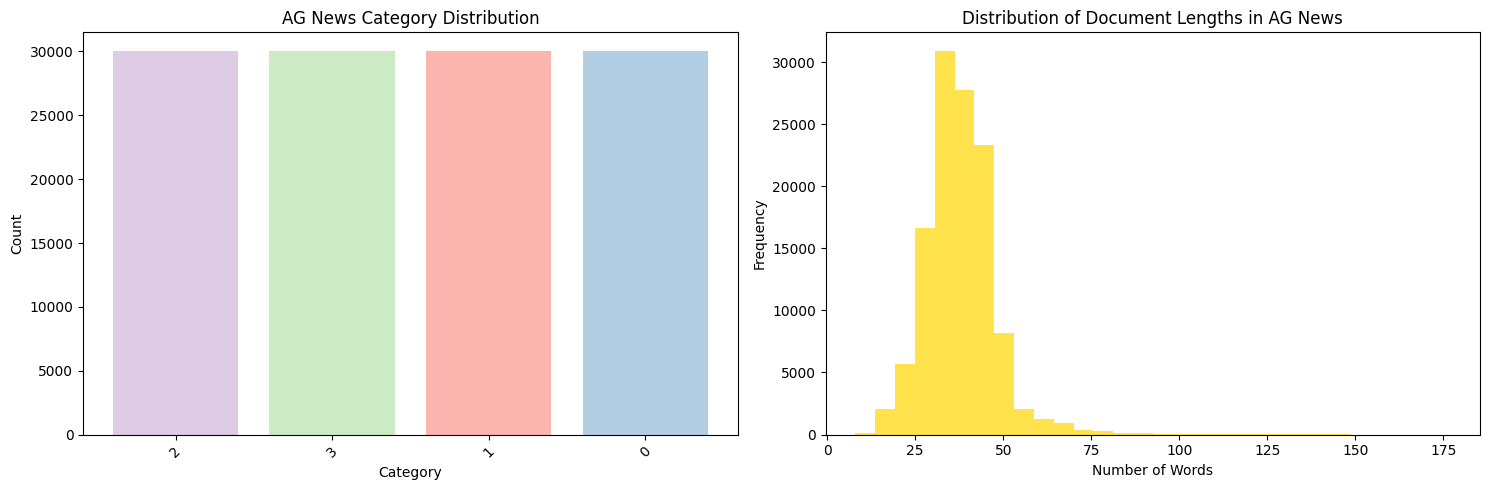

Document Length Statistics:
Mean Length: 37.84745
Max Length: 177
Min Length: 8


In [ ]:
# Calculate and print value counts for labels
label_counts = pd.Series(labels).value_counts()

# Calculate document lengths (number of words in each document)
document_lengths = [len(document.split()) for document in documents]

# Create a 1x2 grid for the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Set up a color palette
palette = sns.color_palette("Pastel1", 4)

# Plot 1: Label Distribution
axes[0].bar(label_counts.index, label_counts.values, color=palette[:4])
axes[0].set_title("AG News Category Distribution")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(len(label_counts.index)))
axes[0].set_xticklabels(label_counts.index, rotation=45)  # Display category names

# Plot 2: Document Length Distribution
axes[1].hist(document_lengths, bins=30, color='gold', alpha=0.7)
axes[1].set_title("Distribution of Document Lengths in AG News")
axes[1].set_xlabel("Number of Words")
axes[1].set_ylabel("Frequency")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Display basic statistics for document lengths
print("Document Length Statistics:")
print("Mean Length:", sum(document_lengths) / len(document_lengths))
print("Max Length:", max(document_lengths))
print("Min Length:", min(document_lengths))


Now that you have separated the training data into samples and descriptive labels, the next step is to format the data into conversational prompts. This structure is essential for training models that need to learn from role-based interactions, such as prompts from a "system," a "user," and a response from the "assistant."

### Format the Data into Conversational Prompts

For this task, each entry in our training data will simulate a conversation:
- **System Prompt**: Sets the task for the model, e.g., asking it to classify a news article.
- **User Prompt**: Contains the actual text of the news article (the `sample`).
- **Assistant Response**: The model’s response, which is the `label` (the descriptive category for the article).


### Explanation of the Code

1. **System Prompt**: Provides context and instructs the model on how to classify each entry.
2. **User Prompt**: The actual news article text, given by the `sample`.
3. **Assistant Response**: The descriptive label for each news article, given by the `label`.

Each `entry` is a dictionary with `"messages"` as a list, containing three dictionaries for `"system"`, `"user"`, and `"assistant"` roles.

### Next Steps

1. **Verify the Output**: Check the formatted data to ensure each entry has the correct structure.
2. **Save the Data**: Once verified, save the formatted data to a JSONL file, which is compatible with Hugging Face and other model training frameworks.

The `formatted_data` itself is a **list of dictionaries** in Python, where each dictionary represents a structured data entry with `system`, `user`, and `assistant` roles.

When you use `json.dumps(formatted_data[0], indent=4)`, it **converts** that first dictionary in the list (`formatted_data[0]`) into a **JSON-formatted string** purely for display purposes. This printed output is human-readable but does not change the actual `formatted_data` structure, which remains a list of dictionaries.

So, to summarize:
- **`formatted_data`**: List of dictionaries (the actual data structure in Python).
- **`json.dumps(formatted_data[0], indent=4)`**: JSON-formatted string for viewing or printing one dictionary entry from `formatted_data` in a readable format.

This way, you can inspect each dictionary as JSON without altering the underlying list of dictionaries, which will be saved or used as-is for training.



In [6]:
import random

# Set sample fraction to reduce run time
sample_fraction = 0.01

# Sample a subset of the training data
train_sample_size = int(len(dataset["train"]["text"]) * sample_fraction)
train_sample_indices = random.sample(range(len(dataset["train"]["text"])), train_sample_size)
train_documents_sample = [dataset["train"]["text"][i] for i in train_sample_indices]
train_labels_sample = [dataset["train"]["label"][i] for i in train_sample_indices]

# Sample a subset of the test data
test_sample_size = int(len(dataset["test"]["text"]) * sample_fraction)
test_sample_indices = random.sample(range(len(dataset["test"]["text"])), test_sample_size)
test_documents_sample = [dataset["test"]["text"][i] for i in test_sample_indices]
test_labels_sample = [dataset["test"]["label"][i] for i in test_sample_indices]

# Define the function to format the data for Hugging Face
def format_data(documents, labels):
    formatted_data = []
    for sample, label in zip(documents, labels):
        entry = {
            "messages": [
                {"role": "system", "content": "Classify the news article into one of these categories: [world, sports, business, sci/tech]"},
                {"role": "user", "content": sample},
                {"role": "assistant", "content": label}
            ]
        }
        formatted_data.append(entry)
    return formatted_data

# Format the sampled training and test data
formatted_train_data = format_data(train_documents_sample, train_labels_sample)
formatted_test_data = format_data(test_documents_sample, test_labels_sample)

# Display the first formatted entry for verification
print("Sample Formatted Training Entry:\n", json.dumps(formatted_train_data[0], indent=4))
print("Sample Formatted Test Entry:\n", json.dumps(formatted_test_data[0], indent=4))



Sample Formatted Training Entry:
 {
    "messages": [
        {
            "role": "system",
            "content": "Classify the news article into one of these categories: [world, sports, business, sci/tech]"
        },
        {
            "role": "user",
            "content": "Cisco tightens security on voice products On Monday, the company announced that it has added new privacy features to its CallManager product, which maps phone numbers to IP addresses and keeps track of phone calls that are made."
        },
        {
            "role": "assistant",
            "content": 3
        }
    ]
}
Sample Formatted Test Entry:
 {
    "messages": [
        {
            "role": "system",
            "content": "Classify the news article into one of these categories: [world, sports, business, sci/tech]"
        },
        {
            "role": "user",
            "content": "Plant a tree at Easter urges Nobel laureate world to plant trees at Easter as a symbol of renewal and to prot

In [7]:
# # Define the system prompt
# system_prompt = "Classify the following news article into one of these categories: [world, sports, business, sci/tech]"

# # Format each sample and label as a conversational prompt
# formatted_data = []
# for sample, label in zip(documents, labels):
#     entry = {
#         "messages": [
#             {"role": "system", "content": system_prompt},
#             {"role": "user", "content": sample},
#             {"role": "assistant", "content": label}
#         ]
#     }
#     formatted_data.append(entry)

# # Display the first formatted entry for verification
# import json
# print("Sample Formatted Entry:\n", json.dumps(formatted_data[0], indent=4))

#### zip(documents, labels) explained

The line `sample, label in zip(documents, labels)` is part of a loop that iterates over both the `documents` and `labels` lists simultaneously, pairing each document (sample) with its corresponding label.

Here’s what’s happening in detail:

- **`zip(documents, labels)`**: Combines the two lists (`documents` and `labels`) into pairs. The result is an iterable where each item is a tuple `(sample, label)`.
  - For example, if `documents = ["Text A", "Text B"]` and `labels = ["Category A", "Category B"]`, `zip(documents, labels)` would produce `[("Text A", "Category A"), ("Text B", "Category B")]`.

- **`for sample, label in zip(documents, labels)`**: Iterates over these pairs. During each loop iteration:
  - `sample` takes the value of the current document (text).
  - `label` takes the value of the corresponding label (category).

### Why It’s Useful
Using `zip` in this way ensures that each `sample` and `label` are processed together, preserving their relationship. This pairing is essential when preparing training data, as it aligns the input (document) with the correct output (label) in each formatted dictionary entry.

It’s important that `zip(documents, labels)` creates an **iterable** because an iterable allows us to **loop over** each `(sample, label)` pair one by one in sequence, without loading all pairs into memory at once. Here’s why this matters:

1. **Efficient Memory Usage**: With large datasets, loading everything into memory at once could be inefficient or impossible due to memory constraints. By creating an iterable, `zip` allows us to process each pair individually, reducing memory overhead.

2. **Sequential Processing**: An iterable enables sequential, on-demand processing. This means we can apply transformations (such as creating the dictionary structure) to each `(sample, label)` pair as we loop through them without having to store all pairs at once.

3. **Flexibility for Lazy Evaluation**: An iterable supports lazy evaluation, meaning the items are only accessed (or created) when they are needed. This can be especially useful in training pipelines where we may want to process data in batches rather than all at once.

4. **Compatibility with For Loops**: Iterables are compatible with Python’s `for` loop, enabling straightforward, readable code when we’re pairing up lists like `documents` and `labels`.

In the context of preparing data for training, using an iterable allows us to **transform and structure data in an efficient, scalable way**, especially important when working with large datasets in machine learning and NLP applications.

### Save to JSONL

The choice to save data in JSONL (JSON Lines) format instead of regular JSON has a few practical advantages, especially for tasks like fine-tuning language models:

1. **Streaming and Memory Efficiency**:
   - JSONL allows you to read and process one entry at a time, making it efficient for large datasets.
   - In contrast, JSON requires loading the entire file into memory, which can be inefficient and even infeasible for very large datasets.

2. **Compatibility with Machine Learning Frameworks**:
   - JSONL format is widely used in machine learning pipelines, where each line represents a single training example.
   - Many NLP libraries (like Hugging Face and OpenAI) and data processing tools expect JSONL for line-by-line data handling, making it a standard format for training, testing, and fine-tuning tasks.

3. **Ease of Append and Modify**:
   - With JSONL, adding or removing data is straightforward because each entry is a self-contained JSON object.
   - JSON files, in contrast, require updating the entire structure if you modify one part, as the entire file is treated as a single object.

4. **Debugging and Processing**:
   - JSONL files are easier to debug and inspect since each line is independent. You can read or analyze individual entries without parsing the whole file.

JSONL is especially useful for handling large datasets or when iterating over entries individually, which makes it highly suitable for our fine-tuning task.

In [8]:
# Save the formatted training data to a JSONL file
with open("training_data.jsonl", "w") as f:
    for entry in formatted_train_data:
        f.write(json.dumps(entry) + "\n")

# Save the formatted test data to a JSONL file
with open("test_data.jsonl", "w") as f:
    for entry in formatted_test_data:
        f.write(json.dumps(entry) + "\n")

### Tokenize the Data
The choice of `max_length=128` is based on a balance between capturing enough context and maintaining efficiency:

1. **Typical Text Length in AG News Dataset**: In many news datasets, including AG News, the average article or snippet length is often well under 128 tokens. Setting `max_length` to 128 allows most articles to fit within this limit without too much truncation.

2. **Computational Efficiency**: Transformer-based models like BERT and DistilBERT process each token individually in self-attention layers, making longer inputs more computationally expensive. By setting `max_length=128`, you keep the sequence length manageable, leading to faster training and inference.

3. **Preserving Context**: With 128 tokens, you generally capture the essential context needed for classification tasks without missing critical information. Shorter text limits, like 64, may cut off necessary context, while longer limits, like 256, would take in more details but add unnecessary computational cost.

4. **Model Constraints**: Many pre-trained models have limits on the maximum number of tokens they can handle (often 512). Keeping it at 128 is a reasonable choice for many tasks, as it uses only part of the model’s capacity, allowing for faster processing.

You can always experiment with different values for `max_length` to see if increasing or decreasing it impacts model performance, especially if you suspect that key information may be getting cut off.

The choice of `max_length=128` is based on a balance between capturing enough context and maintaining efficiency:

1. **Typical Text Length in AG News Dataset**: In many news datasets, including AG News, the average article or snippet length is often well under 128 tokens. Setting `max_length` to 128 allows most articles to fit within this limit without too much truncation.

2. **Computational Efficiency**: Transformer-based models like BERT and DistilBERT process each token individually in self-attention layers, making longer inputs more computationally expensive. By setting `max_length=128`, you keep the sequence length manageable, leading to faster training and inference.

3. **Preserving Context**: With 128 tokens, you generally capture the essential context needed for classification tasks without missing critical information. Shorter text limits, like 64, may cut off necessary context, while longer limits, like 256, would take in more details but add unnecessary computational cost.

4. **Model Constraints**: Many pre-trained models have limits on the maximum number of tokens they can handle (often 512). Keeping it at 128 is a reasonable choice for many tasks, as it uses only part of the model’s capacity, allowing for faster processing.

You can always experiment with different values for `max_length` to see if increasing or decreasing it impacts model performance, especially if you suspect that key information may be getting cut off.

In [9]:
import json
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_data(entry):
    # Extract user text from the entry
    user_text = entry["messages"][1]["content"]
    # Tokenize the user content
    tokenized_output = tokenizer(user_text, padding="max_length", truncation=True, max_length=128)
    # Add the label as an integer
    tokenized_output["labels"] = entry["messages"][2]["content"]
    return tokenized_output

# Load and tokenize the training data
with open("training_data.jsonl", "r") as f:
    tokenized_train_data = [tokenize_data(json.loads(line)) for line in f]

# Load and tokenize the test data
with open("test_data.jsonl", "r") as f:
    tokenized_test_data = [tokenize_data(json.loads(line)) for line in f]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Tune the Model

### Summary of the Steps:
1. **Convert** tokenized data into `Dataset` objects.
2. **Load** the appropriate pretrained model.
3. **Define** training arguments with `TrainingArguments`.
4. **Set up** the `Trainer` class.
5. **Train** the model and **evaluate** its performance.

Each step builds on the last, and following this sequence will help you train the model on your custom dataset efficiently. Let me know if you’d like more detail on any of these steps or have specific questions!

### Step 1: Convert Tokenized Data to Hugging Face Dataset Format
Hugging Face’s `Dataset` class makes it easy to work with data in a structured way. Converting tokenized data to this format allows us to take advantage of Hugging Face’s `Trainer` class for training.














In [10]:
from datasets import Dataset
import pandas as pd

# Convert the tokenized training data to a Hugging Face Dataset
train_dataset = Dataset.from_pandas(pd.DataFrame(tokenized_train_data))
test_dataset = Dataset.from_pandas(pd.DataFrame(tokenized_test_data))

# Check the structure of the data
print("Training Dataset Sample:", train_dataset[0])
print("Test Dataset Sample:", test_dataset[0])

Training Dataset Sample: {'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'input_ids': [101, 26408, 21245, 2015, 3036, 2006, 2376, 3688, 2006, 6928, 1010, 1996, 2194, 2623, 2008, 2009, 2038, 2794, 2047, 9394, 2838, 2000, 2049, 2655, 24805, 4590, 4031, 1010, 2029, 7341, 3042, 3616, 2000, 12997, 11596, 1998, 7906, 2650, 1997, 3042, 4455, 2008, 2024, 2081, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 3}
Test Dataset Samp

### Step 2: Load the Pretrained Model
Load a pretrained model that matches the tokenizer and is suitable for the task (e.g., text classification).

In [11]:
from transformers import AutoModelForSequenceClassification

# Load a pretrained model; ensure it matches the tokenizer used
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 3: Define Training Arguments
The `TrainingArguments` class in Hugging Face allows you to specify parameters such as batch size, learning rate, and output directories.

In [12]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",            # Output directory for model predictions and checkpoints
    eval_strategy="epoch",       # Evaluate at the end of each epoch
    per_device_train_batch_size=8,     # Training batch size per device
    per_device_eval_batch_size=8,      # Evaluation batch size per device
    num_train_epochs=1,                # Number of training epochs
    weight_decay=0.01,                 # Strength of weight decay for regularization
    logging_dir="./logs",              # Directory for storing logs
    logging_steps=10,                  # Log every 10 steps
    report_to="none"                   # Disables W&B logging
)

### Step 4: Set Up the Trainer
The `Trainer` class simplifies the training and evaluation process.


In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,                         # the model to train
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

### Step 5: Start Training
Begin training the model using the `Trainer`.



In [14]:
import time

# Start the timer
start_time = time.time()

# Start training
trainer.train()

# End the timer and calculate duration
end_time = time.time()
duration = (end_time - start_time) / 60  # Convert seconds to minutes
print(f"Training completed in {duration:.2f} minutes.")

Epoch,Training Loss,Validation Loss
1,0.541900,0.364999


Training completed in 13.88 minutes.


### Step 6: Evaluate the Model
After training, evaluate the model’s performance on the test set.





In [15]:
# Evaluate the model on the test set
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 0.36499905586242676, 'eval_runtime': 14.0154, 'eval_samples_per_second': 5.423, 'eval_steps_per_second': 0.714, 'epoch': 1.0}


In [16]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)  # Get the predicted labels

# Assuming your test labels are already in test_dataset['labels']
true_labels = test_dataset['labels']

# Generate and print the classification report
report = classification_report(true_labels, preds, target_names=["world", "sports", "business", "sci/tech"])
print(report)


              precision    recall  f1-score   support

       world       1.00      0.79      0.88        28
      sports       0.94      1.00      0.97        17
    business       0.81      0.93      0.87        14
    sci/tech       0.80      0.94      0.86        17

    accuracy                           0.89        76
   macro avg       0.89      0.91      0.90        76
weighted avg       0.91      0.89      0.89        76



In [ ]:
script_content=r'''

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_label_ratios(label_counts):
    """Calculate positive and negative label ratios."""
    pos_ratio = label_counts['pos'] / label_counts.sum()
    neg_ratio = label_counts['neg'] / label_counts.sum()
    return pos_ratio, neg_ratio

def plot_label_distribution(label_counts, pos_ratio, neg_ratio, title, ax, colors):
    """Plot label distribution with annotated ratios."""
    ax.bar(label_counts.index, label_counts.values, color=colors)
    ax.set_title(title)
    ax.set_xlabel("Sentiment")
    ax.set_ylabel("Count")
    ax.set_xticks(range(len(label_counts.index)))
    ax.set_xticklabels(["Negative", "Positive"])

    # Annotate bars with ratios
    ax.text(0, label_counts['neg'] + 500, f"{neg_ratio:.2%}", ha="center", color="black")
    ax.text(1, label_counts['pos'] + 500, f"{pos_ratio:.2%}", ha="center", color="black")

'''

# Write the script to a file
with open("data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_utils.py")
# Reload script to make functions available for use
import importlib
import data_utils
importlib.reload(data_utils)

from data_utils import *

Script successfully written to data_utils.py


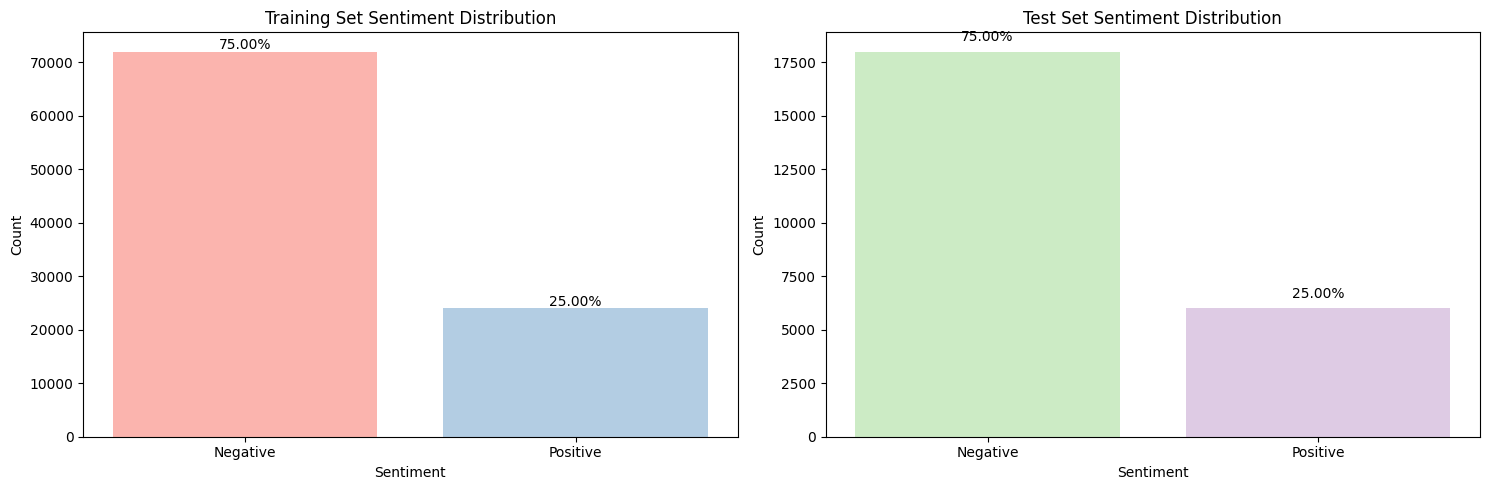

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Calculate label distributions for train and test sets
train_label_counts = pd.Series(train_labels).value_counts()
test_label_counts = pd.Series(test_labels).value_counts()

# Calculate the positive and negative ratios for train and test sets
train_pos_ratio = train_label_counts['pos'] / train_label_counts.sum()
train_neg_ratio = train_label_counts['neg'] / train_label_counts.sum()
test_pos_ratio = test_label_counts['pos'] / test_label_counts.sum()
test_neg_ratio = test_label_counts['neg'] / test_label_counts.sum()

# Set up a color palette
palette = sns.color_palette("Pastel1", 4)

# Create a 1x2 grid for the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Train Label Distribution
axes[0].bar(train_label_counts.index, train_label_counts.values, color=palette[:2])
axes[0].set_title("Training Set Sentiment Distribution")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(len(train_label_counts.index)))
axes[0].set_xticklabels(["Negative", "Positive"])

# Annotate bars with the ratio values
axes[0].text(0, train_label_counts['neg'] + 500, f"{train_neg_ratio:.2%}", ha="center", color="black")
axes[0].text(1, train_label_counts['pos'] + 500, f"{train_pos_ratio:.2%}", ha="center", color="black")

# Plot 2: Test Label Distribution
axes[1].bar(test_label_counts.index, test_label_counts.values, color=palette[2:])
axes[1].set_title("Test Set Sentiment Distribution")
axes[1].set_xlabel("Sentiment")
axes[1].set_ylabel("Count")
axes[1].set_xticks(range(len(test_label_counts.index)))
axes[1].set_xticklabels(["Negative", "Positive"])

# Annotate bars with the ratio values
axes[1].text(0, test_label_counts['neg'] + 500, f"{test_neg_ratio:.2%}", ha="center", color="black")
axes[1].text(1, test_label_counts['pos'] + 500, f"{test_pos_ratio:.2%}", ha="center", color="black")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
